# Favorita sales forecasting

We will forecast the next seven days of sales at Ecuador's Favorita grocery stores, across a range of products.

Run the cell below to load the necessary modules, set defaults, and load the data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from category_encoders import MEstimateEncoder

def rmsle(y_true: list, y_pred: list) -> float:
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_score = make_scorer(rmsle, greater_is_better=False)

# Set Matplotlib defaults
sns.set_style("darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Load data
df_train = pd.read_csv("../input/favorita-store-sales/train.csv")
df_test = pd.read_csv("../input/favorita-store-sales/test.csv")
df_stores = pd.read_csv("../input/favorita-store-sales/stores.csv")
df_oil = pd.read_csv("../input/favorita-store-sales/oil.csv")
df_holidays = pd.read_csv("../input/favorita-store-sales/holidays_events.csv")
df_transactions = pd.read_csv("../input/favorita-store-sales/transactions.csv")

Notice that we have six different datasets to work with! 
- The provided training set and testing set `df_train` and `df_test` will be our bread and butter, but we also have much more information we can incorporate to improve the accuracy of our predictions. 
- The dataset `df_stores` provides information about the location and type of each store, which could allow us to identify trends based on geographic location.
- The dataset `df_oil` contains the daily oil price, which is known to have a big influence on Ecuador's economy.
- The dataset `df_holidays` contains information on important holidays and events in Ecuador, which could help explain anomalous days on which sales spike or drop.
- The dataset `df_transactions` contains the number of transactions that each store makes on a given day, which for example could be used in tandem with the sales figures to determine average spend per sale.

Finally, we have two other pieces of data not contained in our datasets: 

- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

We will need to take all of this into account, but we will start by creating a baseline model and using it with `df_train` and `df_test`.

Let's take a look at the `df_train` dataset.

In [2]:
df_train.head(20)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


The first 20 items all have zero sales and none are on promotion. This seems a little odd at first, but there could be a couple of reasons for this. First of all, it is 1st January, so the store may be closed. Let's try a different date.

In [3]:
df_train.loc[df_train.date == '2013-01-03']

,id,date,store_nbr,family,sales,onpromotion
3564,3564,2013-01-03,1,AUTOMOTIVE,3.000,0
3565,3565,2013-01-03,1,BABY CARE,0.000,0
3566,3566,2013-01-03,1,BEAUTY,0.000,0
3567,3567,2013-01-03,1,BEVERAGES,919.000,0
3568,3568,2013-01-03,1,BOOKS,0.000,0
...,...,...,...,...,...,...
5341,5341,2013-01-03,9,POULTRY,509.496,0
5342,5342,2013-01-03,9,PREPARED FOODS,66.000,0
5343,5343,2013-01-03,9,PRODUCE,0.000,0
5344,5344,2013-01-03,9,SCHOOL AND OFFICE SUPPLIES,0.000,0


This looks more like what one would expect. It's therefore likely that the store was indeed closed. We will address this later, when we incorporate the `df_holidays` dataset. 

## 1. Data cleaning

For now, let's focus on cleaning up `df_train`. Does it have any missing values?

In [4]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

No missing values! Great! Are the data types correct?

In [5]:
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

Looks like we will need to convert the `date` column into `datetime64` values. Let's do that. 

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

The `id` column is not contributing anything (it is simply a copy of the index), so we should get rid of that.

In [7]:
df_train = df_train.loc[:,'date':'onpromotion']
df_train

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Next, let's check that the data entry is consistent for the `family` feature.

In [8]:
df_train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

There are no obvious issues here; great! We also need to consider whether we need to scale/normalise our data. But our only numeric feature for now is `onpromotion`, so this does not seem necessary. We may need to come back to that once we add the features from the other datasets.

## 2. Baseline model

We can use linear regression as a simple baseline model to compare our results against. But first, we need to encode our categorical features so they have numeric values. Since this is our baseline model, let's keep things simple by using a basic Label Encoder.

In [9]:
X = df_train.copy()
y = X.pop('sales')

date_enc = LabelEncoder()
family_enc = LabelEncoder()
X.date = date_enc.fit_transform(X.date)
X.family = family_enc.fit_transform(X.family)

Note that even though we have two datasets `df_train` and `df_test`, this is not a true train-test split, since `df_test` does not contain a `sales` column. This means that we cannot use `df_test` for testing; instead, we will need to split `df_train` into a training set and a testing set and test on that. Once we have a model that gives a low RMSLE on this, we can then train on the entirety of `df_train` and predict the `sales` values of `df_test`.

Since our dataset `df_train` has over 3 million rows, a test size of 20% should be plenty.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

We are now ready to fit our linear regression model!

In [11]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
predictions = reg_model.predict(X_test)

print(f'Accuracy of model on training data: {reg_model.score(X_train, y_train)}')
print(f'Accuracy of model on testing data: {r2_score(y_test, predictions)}')
print(f'RMSLE: {rmsle(y_test.values, predictions)}')

Accuracy of model on training data: 0.19387053539165477
Accuracy of model on testing data: 0.1920690456186942
RMSLE: 3.686436134651758


The accuracy of the model seems pretty bad on both the training and testing data, but that is to be expected. The model also slightly overfits, but only by a very small margin.

## 3. Picking a better model

A good general-purpose model is the Random Forest model, so we will try that.

In [12]:
reg_model = RandomForestRegressor(random_state=23)
reg_model.fit(X_train, y_train)
predictions = reg_model.predict(X_test)

base_forest_rmsle = rmsle(y_test.values, predictions)
print(f'Accuracy of model on training data: {reg_model.score(X_train, y_train)}')
print(f'Accuracy of model on testing data: {r2_score(y_test, predictions)}')
print(f'RMSLE: {base_forest_rmsle}')

Accuracy of model on training data: 0.9855113833970941
Accuracy of model on testing data: 0.9078590130473214
RMSLE: 0.5489546905034578


This is much better already! The overfitting is more apparent with this model, but overall accuracy and RMSLE have improved a huge amount.

After tuning the hyperparameters, we see that the following produces a better result.

In [13]:
reg_model = RandomForestRegressor(n_estimators=200, min_samples_leaf=2, max_depth=25, max_leaf_nodes=250000, n_jobs=8, random_state=23)
reg_model.fit(X_train, y_train)
predictions = reg_model.predict(X_test)

train_acc = reg_model.score(X_train, y_train)
test_acc = r2_score(y_test, predictions)
rmsle_score = rmsle(y_test.values, predictions)

print(f'Accuracy of model on training data: {train_acc}')
print(f'Accuracy of model on testing data: {test_acc}')
print(f'RMSLE: {rmsle_score}')
# print(f'Max depths: {[estimator.tree_.max_depth for estimator in reg_model.estimators_]}')
# print(f'Numbers of leaves: {[estimator.tree_.n_leaves for estimator in reg_model.estimators_]}')

Accuracy of model on training data: 0.960866058692087
Accuracy of model on testing data: 0.909054759281911
RMSLE: 0.5340370548147686


This RMSLE is our new score to beat as we move on to the feature engineering stage.

## 4. Feature engineering

### 4.1. Target encoding

Now that we have our Random Forest model set up, let's do some feature engineering to improve its performance. The first thing we can do is improve the encoding of the `family` feature by using *target encoding*. We have over 3 million rows in our dataset, so can safely set some aside for target encoding; in fact, just setting aside 3% of our total dataset should be sufficient. Notice also that each of the categories in the `family` column appears in an equal number of rows. This is a good sign that a target encoding might work well.

In [14]:
X = df_train.copy()
y = X.pop('sales')
date_enc = LabelEncoder()
X.date = date_enc.fit_transform(X.date)

X_encode = X.sample(frac=0.03, random_state=23)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_pretrain = y[X_pretrain.index]
encoder = MEstimateEncoder(cols=['family'], m=10.0)
encoder.fit(X_encode, y_encode)
X_pretrain = encoder.transform(X_pretrain)

Let's test our model again. We will remove some of the hyperparameter settings on the random forest model for now, as our feature engineering will likely result in us needing to change the tuning.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_pretrain, y_pretrain, test_size=0.2, random_state=23)

reg_model = RandomForestRegressor(n_jobs=8, random_state=23)
reg_model.fit(X_train, y_train)
predictions = reg_model.predict(X_test)

train_acc = reg_model.score(X_train, y_train)
test_acc = r2_score(y_test, predictions)
rmsle_score = rmsle(y_test.values, predictions)

print(f'Accuracy of model on training data: {train_acc}')
print(f'Accuracy of model on testing data: {test_acc}')
print(f'RMSLE: {rmsle_score}')
print(f'Better RMSLE: {rmsle_score < base_forest_rmsle}')
# print(f'Max depths: {[estimator.tree_.max_depth for estimator in reg_model.estimators_]}')
# print(f'Numbers of leaves: {[estimator.tree_.n_leaves for estimator in reg_model.estimators_]}')

Accuracy of model on training data: 0.9862433771060769
Accuracy of model on testing data: 0.8941582445797346
RMSLE: 0.5447023665640118
Better RMSLE: True


We see a small improvement in the RMSLE, so we'll keep the encoding.

### 4.2. Autoregression analysis

Since our data has the form of a time series, we need to test for autoregression and restructure it using a *sliding window representation*, which allows past `sales` data to be used as a feature to predict future `sales` data.

We need to be careful with how we use lag here, since for each day of data we have multiple stores with multiple products. Let's check that the numbers of items stocked and the number of stores listed each day are consistent across the dataset.

In [16]:
n_items_per_store = df_train.groupby('store_nbr').date.value_counts()
print(f'Every store stocks the same number of items every day: {n_items_per_store.nunique() == 1}')
n_days_per_store = df_train.groupby('store_nbr').date.count()
print(f'Every store is present in the data set across the same days: {n_days_per_store.nunique() == 1}')
print(f'Every store stocks {n_items_per_store.iloc[0]} items.')
print(f'There are {df_train.store_nbr.nunique()} stores.')

Every store stocks the same number of items every day: True
Every store is present in the data set across the same days: True
Every store stocks 33 items.
There are 54 stores.


We can see that every store stocks 33 items every day, and every store is listed in the dataset on each day. Moreover, there are 54 stores. Thus, any lag in our data should be a multiple of `33*54`, as this is the number of rows in our dataset per day. Since the stores and items listed each day are consistent, each multiple of `33*54` should accurately represent one day of lag.

We therefore plot the autocorrelation function for `sales`, using 740 lags (in multiples of `33*54`) so that we are able to capture potential annual lag. Since our dataset is so huge, we will only plot this for the first 5 stores (so we use multiples of `33*5` instead).

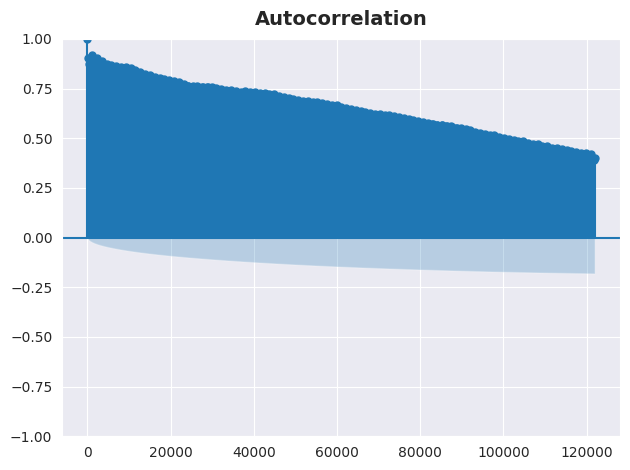

In [17]:
plot_acf(df_train.loc[df_train.store_nbr.isin(range(1,6))].sales.values, lags = [33*5*i for i in range(740)]); # semicolon prevents duplicate plots

There definitely does not seem to be autocorrelation on a yearly scale; in fact, the amount of autocorrelation appears to be decreasing linearly on the large scale. Lets decrease the number of lags to 70 to see if there is any autocorrelation on the monthly or weekly scale.

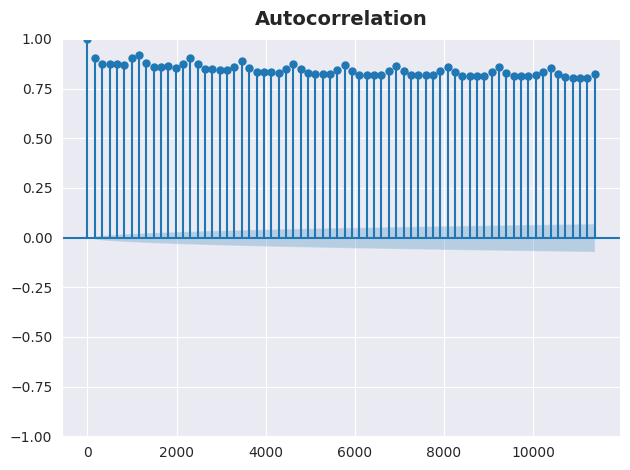

In [18]:
plot_acf(df_train.loc[df_train.store_nbr.isin(range(1,6))].sales.values, lags = [33*5*i for i in range(70)]);

This looks more promising! We can see there is a high degree of autocorrelation if we restrict to at most two months of lag, and in fact the autocorrelation appears to spike weekly. This justifies adding a `sales_last_week` feature. 

Note that we now need to be careful when making our train-test splits; if some of our testing data is from an earlier date than some of our training data, then `sales_last_week` will give our training data undue information about that testing data. We therefore need to make our splits without shuffling the data, so that all the testing data appears after the training data. We also can't use `sales_last_week` in our testing data, except for the first week of the test data; the rest we will have to fill in one week at a time via *walk-forward validation*. To simplify this process, we will only test on the last 15 weeks from `df_train`; this represents 5% of the total data.

In [19]:
X_pretrain['sales_last_week'] = y_pretrain.shift(33*54*7)
X_pretrain.dropna(inplace=True)
y_pretrain = y_pretrain[X_pretrain.index]

X_train, X_test, y_train, y_test = train_test_split(X_pretrain, y_pretrain, test_size=33*54*7*15, shuffle=False)

Let's test our model again. Note that we will also have to test the previous random forest model with this new train-test split, in order to get an accurate picture of whether we have made an improvement.

In [20]:
X_train_old = X_train.drop(columns='sales_last_week')
X_test_old = X_test.drop(columns='sales_last_week')

reg_model = RandomForestRegressor(n_jobs=8, random_state=23)
reg_model.fit(X_train_old, y_train)
predictions = reg_model.predict(X_test_old)

old_train_acc = reg_model.score(X_train_old, y_train)
old_test_acc = r2_score(y_test, predictions)
base_forest_rmsle = rmsle(y_test.values, predictions)

print(f'Accuracy of old model on training data: {old_train_acc}')
print(f'Accuracy of old model on testing data: {old_test_acc}')
print(f'RMSLE: {base_forest_rmsle}')

Accuracy of old model on training data: 0.9867690983448513
Accuracy of old model on testing data: 0.8767156788191243
RMSLE: 0.596316319204942


In [21]:
reg_model = RandomForestRegressor(n_jobs=8, random_state=23)
reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test.iloc[:33*54*7])
for i in range(1,15):
    X_test.iloc[33*54*7*i : 33*54*7*(i+1), -1] = pd.Series(predictions[33*54*7*(i-1):33*54*7*i], index=X_test.iloc[33*54*7*i : 33*54*7*(i+1), -1].index)
    predictions = np.concatenate((predictions, reg_model.predict(X_test.iloc[33*54*7*i : 33*54*7*(i+1)])))

train_acc = reg_model.score(X_train, y_train)
test_acc = r2_score(y_test, predictions)
rmsle_score = rmsle(y_test.values, predictions)

print(f'Accuracy of new model on training data: {train_acc}')
print(f'Accuracy of new model on testing data: {test_acc}')
print(f'RMSLE: {rmsle_score}')
print(f'Better RMSLE: {rmsle_score < base_forest_rmsle}')

previous_rmsle = rmsle_score

Accuracy of new model on training data: 0.9853681825576727
Accuracy of new model on testing data: 0.8857992238514758
RMSLE: 0.5922595096068964
Better RMSLE: True


The RMSLE has improved and there is less overfitting now, too. Great!

### 4.3. Anomaly detection

We know that there was a big earthquake on April 16, 2016 which greatly affected sales for weeks afterwards. We are therefore expecting significant anomalies in the sales figures around this time. Let's visualise our data to see if this is the case.

<Axes: xlabel='year_month', ylabel='sales'>

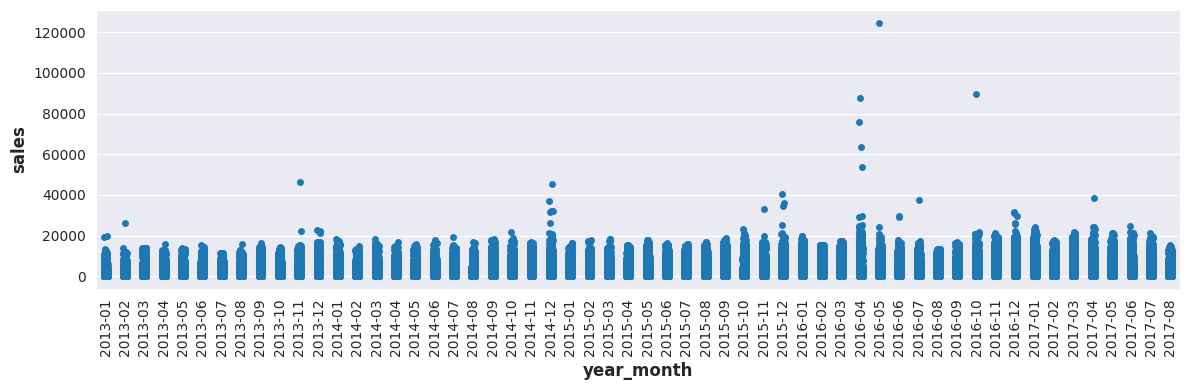

In [22]:
df_plot = df_train.copy()
df_plot['year_month'] = df_plot['date'].dt.to_period('M')
fig, ax = plt.subplots(figsize=(12, 4))
ax.tick_params(axis='x', rotation=90)
sns.stripplot(x='year_month', y='sales', ax=ax, data=df_plot)

We indeed see a huge spike in April and May 2016. There also seems to be an unexpected spike in October 2016. Let's look at the 2016 sales week-by-week.

/tmp/ipykernel_18/530336439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['year_week'] = df_plot['date'].dt.to_period('W')


<Axes: xlabel='year_week', ylabel='sales'>

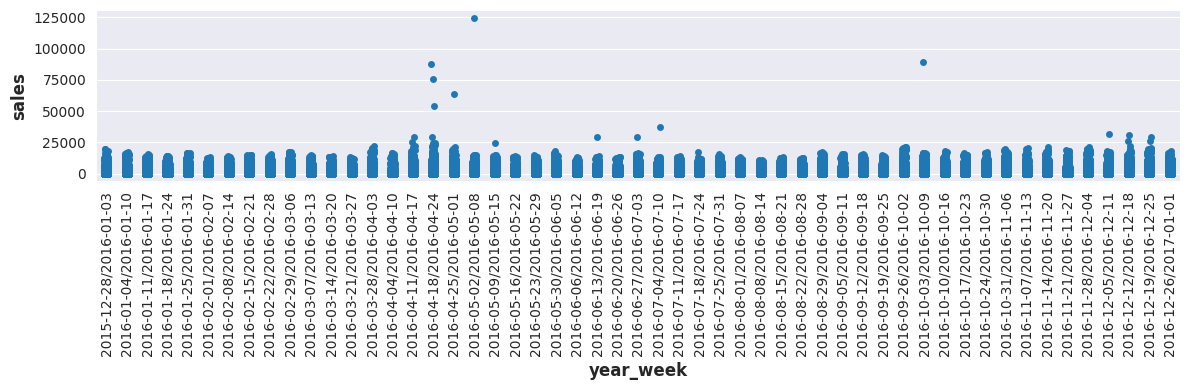

In [23]:
df_plot = df_train.loc[df_train.date.dt.year == 2016]
df_plot['year_week'] = df_plot['date'].dt.to_period('W')
fig, ax = plt.subplots(figsize=(12, 4))
ax.tick_params(axis='x', rotation=90)
sns.stripplot(x='year_week', y='sales', ax=ax, data=df_plot)

Since we don't expect another earthquake, we should get rid of these weeks of data from our dataset. We should also drop the anomalous week in October 2016.

In [24]:
X = df_train.copy()
X = X.drop(X.loc[X.date.between('2016-04-16', '2016-05-13')].index)
X = X.drop(X.loc[X.date.between('2016-10-03', '2016-10-09')].index)
y = X.pop('sales')

Let's see how this affects our model's performance.

In [25]:
date_enc = LabelEncoder()
X.date = date_enc.fit_transform(X.date)
X_encode = X.sample(frac=0.03, random_state=23)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_pretrain = y[X_pretrain.index]
encoder = MEstimateEncoder(cols=['family'], m=10.0)
encoder.fit(X_encode, y_encode)
X_pretrain = encoder.transform(X_pretrain)

X_pretrain['sales_last_week'] = y_pretrain.shift(33*54*7)
X_pretrain.dropna(inplace=True)
y_pretrain = y_pretrain[X_pretrain.index]

X_train, X_test, y_train, y_test = train_test_split(X_pretrain, y_pretrain, test_size=33*54*7*15, shuffle=False)

In [26]:
reg_model = RandomForestRegressor(n_jobs=8, random_state=23)
reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test.iloc[:33*54*7])
for i in range(1,15):
    X_test.iloc[33*54*7*i : 33*54*7*(i+1), -1] = pd.Series(predictions[33*54*7*(i-1):33*54*7*i], index=X_test.iloc[33*54*7*i : 33*54*7*(i+1), -1].index)
    predictions = np.concatenate((predictions, reg_model.predict(X_test.iloc[33*54*7*i : 33*54*7*(i+1)])))

train_acc = reg_model.score(X_train, y_train)
test_acc = r2_score(y_test, predictions)
rmsle_score = rmsle(y_test.values, predictions)

print(f'Accuracy of new model on training data: {train_acc}')
print(f'Accuracy of new model on testing data: {test_acc}')
print(f'RMSLE: {rmsle_score}')
print(f'Better RMSLE: {rmsle_score < previous_rmsle}')

previous_rmsle = rmsle_score

Accuracy of new model on training data: 0.9869745997728832
Accuracy of new model on testing data: 0.8913164847337883
RMSLE: 0.5791904299178592
Better RMSLE: True


Hooray! The RMSLE has improved.

## 5. Final predictions

We now do some final hyperparameter tuning, train our model on the whole dataset `df_train`, and generate predictions for `df_test`.

Let's set everything up from the previous sections.

In [27]:
# Clean data
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_train = df_train.loc[:,'date':'onpromotion']
# Drop anomalies
X = df_train.copy()
X = X.drop(X.loc[X.date.between('2016-04-16', '2016-05-13')].index)
X = X.drop(X.loc[X.date.between('2016-10-03', '2016-10-09')].index)
y = X.pop('sales')
# Target encoding
date_enc = LabelEncoder()
X.date = date_enc.fit_transform(X.date)
X_encode = X.sample(frac=0.03, random_state=23)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_pretrain = y[X_pretrain.index]
encoder = MEstimateEncoder(cols=['family'], m=10.0)
encoder.fit(X_encode, y_encode)
X_pretrain = encoder.transform(X_pretrain)
# Autoregression feature
X_pretrain['sales_last_week'] = y_pretrain.shift(33*54*7)
X_pretrain.dropna(inplace=True)
y_pretrain = y_pretrain[X_pretrain.index]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pretrain, y_pretrain, test_size=33*54*7*15, shuffle=False)

After tuning the hyperparameters, we get the following improved model. Note that increasing the number of estimators improves the RMSLE, but not in a meaningful way (less than 0.0001), so the large increase in runtime is not worthwhile.

In [28]:
reg_model = RandomForestRegressor(min_samples_leaf=10, max_depth=25, max_leaf_nodes=70000, max_features=0.9, n_jobs=8, random_state=23)
reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test.iloc[:33*54*7])
for i in range(1,15):
    X_test.iloc[33*54*7*i : 33*54*7*(i+1), -1] = pd.Series(predictions[33*54*7*(i-1):33*54*7*i], index=X_test.iloc[33*54*7*i : 33*54*7*(i+1), -1].index)
    predictions = np.concatenate((predictions, reg_model.predict(X_test.iloc[33*54*7*i : 33*54*7*(i+1)])))

train_acc = reg_model.score(X_train, y_train)
test_acc = r2_score(y_test, predictions)
rmsle_score = rmsle(y_test.values, predictions)

print(f'Accuracy of new model on training data: {train_acc}')
print(f'Accuracy of new model on testing data: {test_acc}')
print(f'RMSLE: {rmsle_score}')
print(f'Better RMSLE: {rmsle_score < previous_rmsle}')
# print(f'Max depths: {[estimator.tree_.max_depth for estimator in reg_model.estimators_]}')
# print(f'Numbers of leaves: {[estimator.tree_.n_leaves for estimator in reg_model.estimators_]}')

Accuracy of new model on training data: 0.9267329848940897
Accuracy of new model on testing data: 0.9038897058583352
RMSLE: 0.5082859867729965
Better RMSLE: True


Now let's train on the whole of `df_train` and generate predictions!

In [29]:
# Clean data
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')
df_train = df_train.loc[:,'date':'onpromotion']
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d')
X_test = df_test.loc[:,'date':'onpromotion']
# Drop anomalies
X = df_train.copy()
X = X.drop(X.loc[X.date.between('2016-04-16', '2016-05-13')].index)
X = X.drop(X.loc[X.date.between('2016-10-03', '2016-10-09')].index)
y = X.pop('sales')
# Target encoding
date_enc = LabelEncoder()
X.date = date_enc.fit_transform(X.date)
X_test.date = date_enc.fit_transform(X_test.date)
X_encode = X.sample(frac=0.03, random_state=23)
y_encode = y[X_encode.index]
X_train = X.drop(X_encode.index)
y_train = y[X_train.index]
encoder = MEstimateEncoder(cols=['family'], m=10.0)
encoder.fit(X_encode, y_encode)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)
# Autoregression feature
X_train['sales_last_week'] = y_train.shift(33*54*7)
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]
X_test['sales_last_week'] = pd.Series([0 for i in X_test.index], index=X_test.index, name='sales_last_week')
X_test.iloc[:33*54*7, -1] = y_train.iloc[-33*54*7:]

In [30]:
reg_model = RandomForestRegressor(min_samples_leaf=10, max_depth=25, max_leaf_nodes=70000, max_features=0.9, n_jobs=8, random_state=23)
reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test.iloc[:33*54*7])
X_test.iloc[33*54*7 : 33*54*7*2, -1] = pd.Series(predictions[:33*54*7], index=X_test.iloc[33*54*7 : 33*54*7*2, -1].index)
predictions = np.concatenate((predictions, reg_model.predict(X_test.iloc[33*54*7 : 33*54*7*2])))
X_test.iloc[33*54*7*2 : 33*54*16, -1] = pd.Series(predictions[33*54*7:33*54*9], index=X_test.iloc[33*54*7*2 : 33*54*16, -1].index)
predictions = np.concatenate((predictions, reg_model.predict(X_test.iloc[33*54*7*2 : 33*54*16])))

df_pred = pd.DataFrame({'id': df_test.id, 'sales': predictions})
df_pred

,id,sales
0,3000888,2.148663
1,3000889,0.023737
2,3000890,14.006014
3,3000891,1964.130539
4,3000892,0.020551
...,...,...
28507,3029395,423.174489
28508,3029396,50.812033
28509,3029397,274.700034
28510,3029398,123.755000


Finally, we save our results to a `csv` file.

In [31]:
df_pred.to_csv("predictions.csv", index=False)

## (6. Adding more features)

We will address this in a later version.

## (7. Principal component analysis)

We will address this in a later version.